In [1]:
import sys, os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *

In [2]:
with open('../data/results.pkl', 'rb') as f:
    results = pickle.load(f)

df = pd.read_csv('../data/test_cases.csv', usecols=range(0, 14))

In [3]:
df.head()
losses, rewards, mean_reward, fig1, fig2 = results[30]

In [4]:
mean_rewards = []

mean_reward

0.0

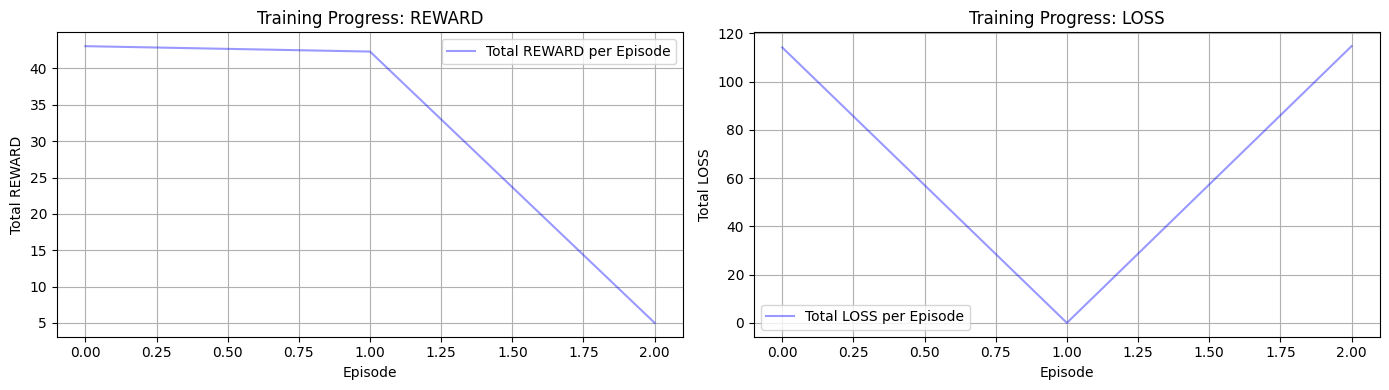

In [5]:
show_figure(fig1)
plt.show()

In [6]:
mean_rewards = []

for index, row in df.iterrows():
    mean_reward = results[index][2]  
    mean_rewards.append(mean_reward)
df['mean_reward'] = mean_rewards

In [7]:
df['European_Price'] = df.apply(
    lambda row: black_scholes(
        s=row['s_0'],
        k=100, 
        t1 = 0,
        t2=row['t2'],
        r=row['r'],
        v=row['v'] if not np.isnan(row['v']) else row['sigma'],  
        q = row['q'],
        call=row['h'].split('_')[-1].lower() == "call"
    ),
    axis=1
)

In [8]:
k = 100
call = partial(lambda x, k: np.maximum(x - k, 0), k=k)
put = partial(lambda x, k: np.maximum(k - x, 0), k=k)

df['MC_Price'] = df.apply(
    lambda row: get_mc_price(
        generate_gbm_paths(
            nsim=1000,
            nstep=int(365 * row["t2"]),  
            t1=0,
            t2=row["t2"],
            s_0=row["s_0"],
            r=row["r"],
            q=row["q"],
            v=row["v"]
        ) if row["gbm"] else generate_heston_paths(
            nsim=1000,
            nstep=int(365 * row["t2"]),
            t1=0,
            t2=row["t2"],
            s_0=row["s_0"],
            r=row["r"],
            q=row["q"],
            v_0=row["v_0"],
            theta=row["theta"],
            rho=row["rho"],
            kappa=row["kappa"],
            sigma=row["sigma"]
        ),
        t1=0,
        t2=row["t2"],
        h=(call if row["h"].split('_')[-1].lower() == "call" else put), 
        r=row["r"]
    ),
    axis=1
)

In [9]:
#df[(df["case"] == "Base_Case") & (df["gbm"] == True)]
df[(df["case"] == "Base_Case") ]

,case,s_0,v,t2,q,r,h,v_0,theta,rho,kappa,sigma,gbm,notes,mean_reward,European_Price,MC_Price
0,Base_Case,80,0.2,1.0,0.0,0.04,American_Put,NaN,NaN,NaN,NaN,NaN,True,"Base case with changing S_0, σ, and T for Amer...",20.884124,17.784517,20.089774
1,Base_Case,80,NaN,1.0,0.0,0.04,American_Put,0.04,0.04,-0.7,2.0,0.2,False,"Base case with changing S_0, σ, and T for Amer...",14.978399,17.784517,20.063758
2,Base_Case,80,0.2,2.0,0.0,0.04,American_Put,NaN,NaN,NaN,NaN,NaN,True,"Base case with changing S_0, σ, and T for Amer...",21.812924,17.049533,20.570150
3,Base_Case,80,NaN,2.0,0.0,0.04,American_Put,0.04,0.04,-0.7,2.0,0.2,False,"Base case with changing S_0, σ, and T for Amer...",13.990340,17.049533,20.132616
4,Base_Case,80,0.4,1.0,0.0,0.04,American_Put,NaN,NaN,NaN,NaN,NaN,True,"Base case with changing S_0, σ, and T for Amer...",18.046839,23.409238,23.969302
5,Base_Case,80,NaN,1.0,0.0,0.04,American_Put,0.16,0.16,-0.7,2.0,0.4,False,"Base case with changing S_0, σ, and T for Amer...",16.194310,23.409238,24.876514
6,Base_Case,80,0.4,2.0,0.0,0.04,American_Put,NaN,NaN,NaN,NaN,NaN,True,"Base case with changing S_0, σ, and T for Amer...",23.534530,25.936587,28.567579
7,Base_Case,80,NaN,2.0,0.0,0.04,American_Put,0.16,0.16,-0.7,2.0,0.4,False,"Base case with changing S_0, σ, and T for Amer...",3.524050,25.936587,26.869030
8,Base_Case,90,0.2,1.0,0.0,0.04,American_Put,NaN,NaN,NaN,NaN,NaN,True,"Base case with changing S_0, σ, and T for Amer...",11.728496,10.841383,11.990833
9,Base_Case,90,NaN,1.0,0.0,0.04,American_Put,0.04,0.04,-0.7,2.0,0.2,False,"Base case with changing S_0, σ, and T for Amer...",7.989395,10.841383,11.486682


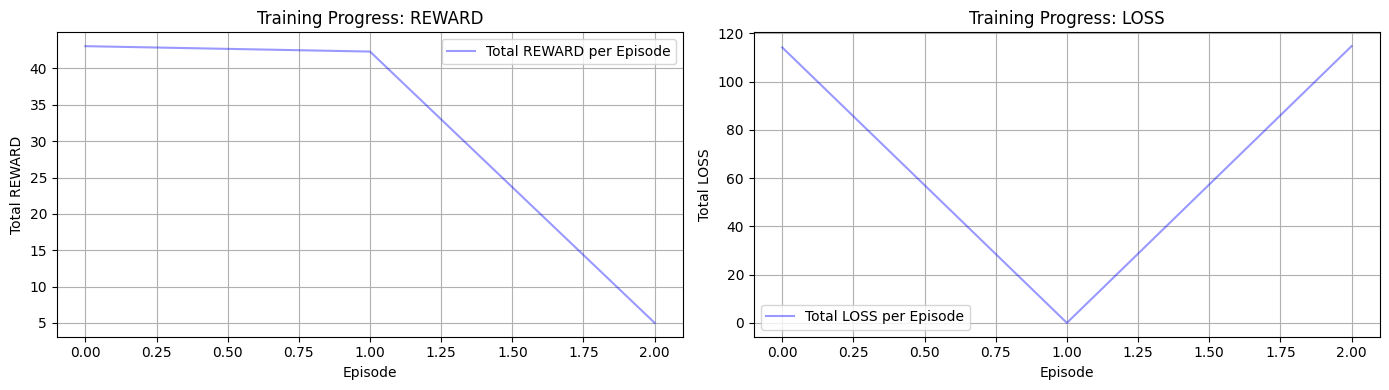

In [10]:
fig1

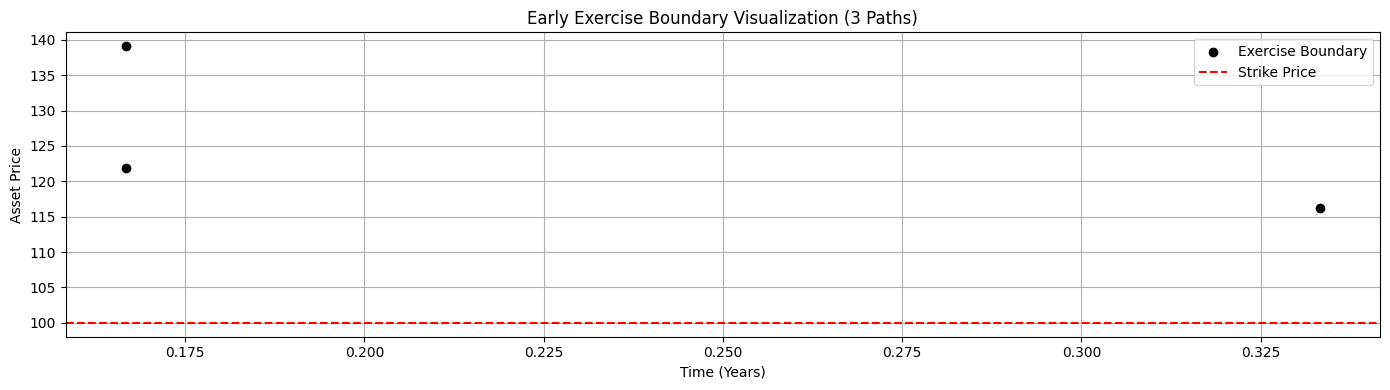

In [11]:
fig2
